In [1]:
!pip install accelerate peft bitsandbytes transformers trl


In [1]:
import torch
from datasets import load_dataset, Dataset
from peft import LoraConfig, AutoPeftModelForCausalLM
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments
from trl import SFTTrainer
import os

In [5]:
# first mention dataset name
#dataset="burkelibbey/colors"
dataset="bentrevett/multi30k"
# then specify model, we use chat for shorter trainer time, we will try base later
model_id="google/gemma-2b"
# define output directory
#output_model="tinyllama-colorist-v1"
output_model="gemma-2b-multi30k-v1"

Don't run the next block if you want to use tinyllama

In [6]:
# model_id="Tyrannosaurus/TinyGPT-V"
# output_model="tinygpt"

# data prep

In [7]:
# we need to reformat the data in teh ChatML format.

def formatted_train(input,response)->str:
    return f"<bos><|im_start|>user\n{input}<|im_end|>\n<|im_start|>assistant\n{response}<|im_end|>\n"

In [8]:
# loads dataset with hugging face datasets
# turns the dataset into pandas dataframe
# picks the record from data frame
# then, adds the formatted instruction to tune. e.g., what the input is expected and what the output should be.
# lastly, returns a hugging face format dataset instead of a dataframe
# def prepare_train_data(data_id):
#     data = load_dataset(data_id, split="train")
#     data_df = data.to_pandas()
#     data_df["text"] = data_df[["description", "color"]].apply(lambda x: "<|im_start|>user\n" + x["description"] + " <|im_end|>\n<|im_start|>assistant\n" + x["color"] + "<|im_end|>\n", axis=1)
#     data = Dataset.from_pandas(data_df)
#     return data

def prepare_train_data_multi_30k(data_id):
    data = load_dataset(data_id, split="train")
    data_df = data.to_pandas()
    data_df["text"] = data_df[["de", "en"]].apply(lambda x: "<bos><|im_start|>user\n" + x["de"] + " <|im_end|>\n<|im_start|>assistant\n" + x["en"] + "<|im_end|>\n", axis=1)
    data = Dataset.from_pandas(data_df)
    return data

In [9]:
data = prepare_train_data_multi_30k(dataset)

In [10]:
data

Dataset({
    features: ['en', 'de', 'text'],
    num_rows: 29000
})

In [11]:
data[0] # notice the description, and the text

{'en': 'Two young, White males are outside near many bushes.',
 'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.',
 'text': '<bos><|im_start|>user\nZwei junge weiße Männer sind im Freien in der Nähe vieler Büsche. <|im_end|>\n<|im_start|>assistant\nTwo young, White males are outside near many bushes.<|im_end|>\n'}

In [12]:
def get_model_and_tokenizer(mode_id):
    # use tokenizer from llama2
    tokenizer = AutoTokenizer.from_pretrained('philschmid/gemma-tokenizer-chatml')
    tokenizer.pad_token = tokenizer.eos_token
    # uses bits and bytes package
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype="float16", bnb_4bit_use_double_quant=True
    )
    # loads the model
    model = AutoModelForCausalLM.from_pretrained(
        mode_id, quantization_config=bnb_config, device_map="auto"
    )
    model.config.use_cache=False
    model.config.pretraining_tp=1
    # returns a model and tokenizer
    return model, tokenizer

In [13]:
# !pip install -i https://test.pypi.org/simple/bitsandbytes

In [14]:
model, tokenizer = get_model_and_tokenizer(model_id)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

======== BELOW IS CODE FOR PHI2. Ignore it

In [15]:
#!pip install transformers==4.36

In [ ]:
# model = AutoModelForCausalLM.from_pretrained("susnato/phi-2")
# tokenizer = AutoTokenizer.from_pretrained("susnato/phi-2")

In [17]:
# if tokenizer.pad_token is None:
#     tokenizer.add_special_tokens({'pad_token': '[PAD]'})
#     model.resize_token_embeddings(len(tokenizer))

============

In [16]:
# setup Lora configurations
peft_config = LoraConfig( # we can have different configurations, will test later
        r=8, lora_alpha=16, lora_dropout=0.05, bias="none", task_type="CAUSAL_LM", target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
    )

In [17]:
training_arguments = TrainingArguments(
        output_dir=output_model,
        per_device_train_batch_size=8,
        gradient_accumulation_steps=4,
        optim="paged_adamw_32bit",
        learning_rate=2e-4,
        lr_scheduler_type="cosine",
        save_strategy="epoch",
        logging_steps=10,
        num_train_epochs=3,
        max_steps=1,
        fp16=True,
        # push_to_hub=True
    )

In [18]:
trainer = SFTTrainer(
        model=model,
        train_dataset=data,
        peft_config=peft_config,
        dataset_text_field="text",
        args=training_arguments,
        tokenizer=tokenizer,
        packing=False,
        max_seq_length=1024
    )

Map:   0%|          | 0/29000 [00:00<?, ? examples/s]

/home/hamad.alhammadi/.conda/envs/pytorch-intro/lib/python3.9/site-packages/trl/trainer/sft_trainer.py:290: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(


In [19]:
torch.cuda.empty_cache() 

In [20]:
trainer.train()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
wandb: Currently logged in as: 7ammadi21 (7ammadi). Use `wandb login --relogin` to force relogin
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 12.7014, 'train_samples_per_second': 2.519, 'train_steps_per_second': 0.079, 'train_loss': 5.782793045043945, 'epoch': 0.0}


TrainOutput(global_step=1, training_loss=5.782793045043945, metrics={'train_runtime': 12.7014, 'train_samples_per_second': 2.519, 'train_steps_per_second': 0.079, 'train_loss': 5.782793045043945, 'epoch': 0.0})

# Using Lora

In [12]:
from peft import AutoPeftModelForCausalLM, PeftModel
from transformers import AutoModelForCausalLM
import torch
import os

model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.float16, load_in_8bit=False,
                                             device_map="auto",
                                             trust_remote_code=True)

#model_path = "/content/tinyllama-colorist-v1/checkpoint-250"
model_path = "gemma-2b-multi30k-v1/checkpoint-250"

peft_model = PeftModel.from_pretrained(model, model_path, from_transformers=True, device_map="auto")

model = peft_model.merge_and_unload()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [13]:
model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): GELUActivation()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
    (norm): GemmaRM

# LLM Inference

In [15]:
from transformers import GenerationConfig
from time import perf_counter

def generate_response(user_input):

  prompt = formatted_prompt(user_input)

  inputs = tokenizer([prompt], return_tensors="pt")
  generation_config = GenerationConfig(penalty_alpha=0.6,do_sample = True,
      top_k=5,temperature=0.5,repetition_penalty=1.2,
      max_new_tokens=12,pad_token_id=tokenizer.eos_token_id
  )
  start_time = perf_counter()

  inputs = tokenizer(prompt, return_tensors="pt").to('cuda')

  outputs = model.generate(**inputs, generation_config=generation_config)
  output=tokenizer.decode(outputs[0], skip_special_tokens=True)
  #print(output)
  output_time = perf_counter() - start_time
  #print(f"Time taken for inference: {round(output_time,2)} seconds")
  return output

In [14]:
def formatted_prompt(question)-> str:
    return f"<bos><|im_start|>user\n{question}<|im_end|>\n<|im_start|>assistant:"

In [45]:
data_test = load_dataset(dataset, split="test")

In [46]:
data_test

Dataset({
    features: ['en', 'de'],
    num_rows: 1000
})

In [47]:
data_test[0] # notice the description, and the text

{'en': 'A man in an orange hat starring at something.',
 'de': 'Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt.'}

In [16]:
import nltk
import pandas as pd
import re

In [49]:
#generate_response(user_input='color of black')

In [50]:
generate_response(user_input='Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt.')

'user\nEin Mann mit einem orangefarbenen Hut, der etwas anstarrt.\nassistant: A man with an orange hat looking at something.�\n'

In [53]:
out=generate_response(user_input=data_test[0]['de'])
out=out.split('assistant:')[-1].strip()
processed_out=re.sub("[^A-Za-z0-9., ]","",out)
print(processed_out)

A man with an orange hat staring at something. afforr


In [58]:
input_de=[]
output_en=[]
gt_en=[]

for r in data_test:
  input_de.append(r["de"])
  out=generate_response(user_input=r["de"])
  out=str(out).split('assistant:')[-1].strip()
  processed_out=re.sub("[^A-Za-z., ]","",out)
  output_en.append(processed_out)
  gt_en.append(r["en"])

test_translation={
    'input_de':input_de,
    'output_en':output_en,
    "gt_en":gt_en
}
test_translation_df=pd.DataFrame(test_translation)
test_translation_df.to_csv('initial_attemtpt_gemma_multi30k.csv')

In [19]:
from nltk.translate.bleu_score import corpus_bleu,  SmoothingFunction
from nltk.tokenize import word_tokenize
import csv
import matplotlib.pyplot as plt

In [20]:
df = pd.read_csv('initial_attemtpt_gemma_multi30k.csv')
# print if there are any nan values
print(df.isnull().sum())
# drop nan values
df = df.dropna()

Unnamed: 0     0
input_de       0
output_en     19
gt_en          0
dtype: int64


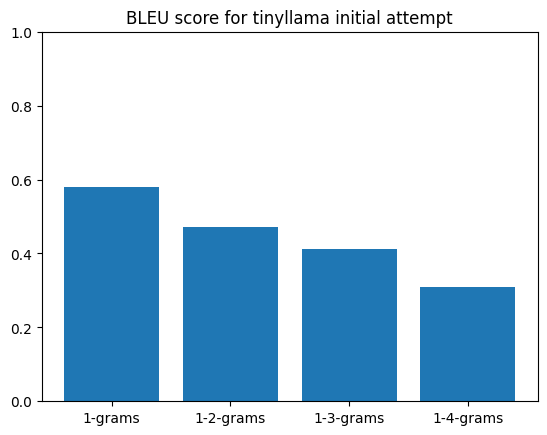

In [21]:
def bleu_score(csv_file):
  df_input=pd.read_csv(csv_file)
  df_input = df.dropna()
  actual, predicted=[],[]
  count=0
  for _, r in df_input.iterrows():
    #print(r["input_de"])
    #print(r["output_en"])
    #print(r["gt_en"])
    actual.append([r["gt_en"].split()])
    predicted.append(r["output_en"].split())
  #print(actual)
  #print("===")
  #print(predicted)

  bleu_dic={}
  bleu_dic['1-grams']=corpus_bleu(actual, predicted, weights=(1.0,0,0,0))
  bleu_dic['1-2-grams']=corpus_bleu(actual, predicted, weights=(0.5,0.5,0,0))
  bleu_dic['1-3-grams']=corpus_bleu(actual, predicted, weights=(0.3,0.3,0.3,0))
  bleu_dic['1-4-grams']=corpus_bleu(actual, predicted, weights=(0.25,0.25,0.25,0.25))
  return bleu_dic

tinyllama_bleu=bleu_score('initial_attemtpt_gemma_multi30k.csv')

plt.bar(x=tinyllama_bleu.keys(), height=tinyllama_bleu.values())
plt.title("BLEU score for tinyllama initial attempt")
plt.ylim((0,1))
plt.show()

In [22]:
tinyllama_bleu

{'1-grams': 0.5786995659176797,
 '1-2-grams': 0.4706711493253154,
 '1-3-grams': 0.41288084622307836,
 '1-4-grams': 0.3103266395412101}

In [66]:
from nltk.translate.bleu_score import sentence_bleu

def bleu_sent_score(csv_file):
  df_input=pd.read_csv(csv_file)
  actual, predicted=[],[]
  count=0
  scores = []
  for _, r in df_input.iterrows():
    #print(r["input_de"])
    #print(r["output_en"])
    #print(r["gt_en"])
    actual.append([r["gt_en"].split()])
    predicted.append(r["output_en"].split())

    score = sentence_bleu([r["gt_en"].split()], r["output_en"].split())
    scores.append(score)



  return scores


tinyllama_bleu_sent=bleu_sent_score('initial_attemtpt_tinyLlama_multi30k.csv')
import numpy as np
np.array(tinyllama_bleu_sent).mean()
    

/home/hamad.alhammadi/.conda/envs/pytorch-intro/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/hamad.alhammadi/.conda/envs/pytorch-intro/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/hamad.alhammadi/.conda/envs/pytorch-intro/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlap

0.14707169651428462

In [ ]:
# pip install accelerate
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("google/gemma-2b")
model = AutoModelForCausalLM.from_pretrained("google/gemma-2b", device_map="auto")

input_text = "Write me a poem about Machine Learning."
input_ids = tokenizer(input_text, return_tensors="pt").to("cuda")

outputs = model.generate(**input_ids)
print(tokenizer.decode(outputs[0]))


Meteor

In [30]:
import nltk
import numpy as np
nltk.download('wordnet')
from nltk.translate.meteor_score import meteor_score
df_input = pd.read_csv('initial_attemtpt_gemma_multi30k.csv')
df_input = df_input.dropna()
actual, predicted = df_input['gt_en'], df_input['output_en']
scores=[]
for reference, hypothesis in zip(actual, predicted):
    tokenized_reference = word_tokenize(reference)
    tokenized_hypothesis = word_tokenize(hypothesis)
    scores.append(meteor_score([tokenized_reference], tokenized_hypothesis))

np.array(scores).mean()

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/hamad.alhammadi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0.6175170234321976

Comet

In [33]:
!pip install unbabel-comet

  Obtaining dependency information for unbabel-comet from https://files.pythonhosted.org/packages/6e/a1/ee4d2a587c4bcc2de344c1838353d0604bc3e905d5725920dab2218fb4a3/unbabel_comet-2.2.1-py3-none-any.whl.metadata
  Using cached unbabel_comet-2.2.1-py3-none-any.whl.metadata (15 kB)
  Obtaining dependency information for entmax<2.0,>=1.1 from https://files.pythonhosted.org/packages/06/a0/71747f0d98e441d0670b06205afd24d832e88c0ee62129ca47ce88505304/entmax-1.3-py3-none-any.whl.metadata
  Using cached entmax-1.3-py3-none-any.whl.metadata (348 bytes)
  Obtaining dependency information for jsonargparse==3.13.1 from https://files.pythonhosted.org/packages/04/cf/b8bdb5d6b631766a2332dca19cb2b214620a65c398636012dde69b71f36f/jsonargparse-3.13.1-py3-none-any.whl.metadata
  Using cached jsonargparse-3.13.1-py3-none-any.whl.metadata (55 kB)
  Obtaining dependency information for pytorch-lightning<3.0.0,>=2.0.0 from https://files.pythonhosted.org/packages/56/ed/192d7518b15a06452f480346eeebe1d1d4595af806

In [36]:
from evaluate import load
comet_metric = load("comet")
predicted = df_input['output_en']
actual = df_input['gt_en']
source = df_input['input_de']
results = comet_metric.compute(predictions=predicted, references=actual, sources=source)


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/3.53k [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

hparams.yaml:   0%|          | 0.00/567 [00:00<?, ?B/s]

LICENSE:   0%|          | 0.00/9.69k [00:00<?, ?B/s]

model.ckpt:   0%|          | 0.00/2.32G [00:00<?, ?B/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.2.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/371e9839ca4e213dde891b066cf3080f75ec7e72/checkpoints/model.ckpt`


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

Encoder model frozen.
/home/hamad.alhammadi/.conda/envs/pytorch-intro/lib/python3.9/site-packages/pytorch_lightning/core/saving.py:188: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
/home/hamad.alhammadi/.conda/envs/pytorch-intro/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/hamad.alhammadi/.conda/envs/pytorch-intro/lib/ ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more de

In [37]:
results

{'mean_score': 0.7793841325847867,
 'scores': [0.9191362261772156,
  0.80643630027771,
  0.7037695050239563,
  0.8792409300804138,
  0.7907422184944153,
  0.6432418823242188,
  0.9267314076423645,
  0.5855204463005066,
  0.7840875387191772,
  0.8841508626937866,
  0.8591406345367432,
  0.6213380694389343,
  0.9466983675956726,
  0.8226258754730225,
  0.7801116704940796,
  0.8551514744758606,
  0.8241301774978638,
  0.7016523480415344,
  0.7055469751358032,
  0.7025972604751587,
  0.7869605422019958,
  0.8875196576118469,
  0.7946357131004333,
  0.8981350064277649,
  0.746684193611145,
  0.7848634123802185,
  0.8422688841819763,
  0.6508674025535583,
  0.5656773447990417,
  0.9357622265815735,
  0.8968157172203064,
  0.599843442440033,
  0.7027828097343445,
  0.9487603306770325,
  0.7292593717575073,
  0.7130081057548523,
  0.8258240818977356,
  0.7219931483268738,
  0.550763726234436,
  0.7208603620529175,
  0.7829266786575317,
  0.5717723965644836,
  0.8900822401046753,
  0.7887102961